## Redes Neuronales Convolucionales (Transfer Learning y Fine Tuning)

#### Ejercicio 1

A partir de un dataset de residuos sólidos, utilizar o generar un modelo preentrenado (de acuerdo a elección, el mismo no deberá ser inferior al año 2019), debe lograr conseguir un error menor al 15% y una precisión superior al 90% en clasificación de al menos 5 clases de residuos sólidos. Entrenar el modelo utilizando transfer learning y fine tunning de acuerdo al modelo asignado, analizar y explicar los resultados obtenidos. (El modelo de red elegido debe ser comunicado a su compañero) (Obligatoria para todos).

En este ejercicio vamos a utilizar el modelo pre-entrenado ResNeSt-101(2019) para clasificar imágenes de residuos solidos de 5 clases.

In [1]:
# importamos las librerias que vamos a utilizar en el notebook
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# Device configuration (GPU o CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Dataset

Usaremos el dataset de residuos sólidos de 5 clases que se encuentra en el siguiente link: https://www.kaggle.com/datasets/imrshu/solidwaste?select=dataset 

Cargamos el dataset y lo dividimos en train y test con ImageFolder, hacemos un resize de 64x64 y lo convertimos a tensores.

In [15]:
# Ruta donde se almacenarán los datos solid_waste
root_test = 'datasets/solid_waste/test/'
root_train = 'datasets/solid_waste/train/'
 
# Aplicar otras transformaciones necesarias
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Cargar datos de entrenamiento con la transformación personalizada
train = ImageFolder(root=root_train, transform=transform)
test = ImageFolder(root=root_test, transform=transform)
# las clases 
classes = ('Cardboard', 'Glass', 'Metal', 'Paper', 'Plastic')

In [3]:
# mostramos la estructura del dataset
train

Dataset ImageFolder
    Number of datapoints: 3459
    Root location: datasets/solid_waste/train/
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

Lo cargamos a un DataLoader para poder iterar sobre el de manera más eficiente, esta vez con un batch_size de 64 en train y 128 en test.

In [4]:
# cargamos los datos en un dataloader
dataloader = {
    'train': torch.utils.data.DataLoader(train, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)
}

In [5]:
# mostramos una muestra para verificar que todo este bien
imgs, lab = next(iter(dataloader['train']))
imgs.shape, imgs.dtype, imgs.min(), imgs.max(), lab.shape

(torch.Size([64, 3, 64, 64]),
 torch.float32,
 tensor(0.),
 tensor(1.),
 torch.Size([64]))

Mostramos algunas imágenes de ejemplo del dataset para ver con que tipo de imágenes estamos trabajando.

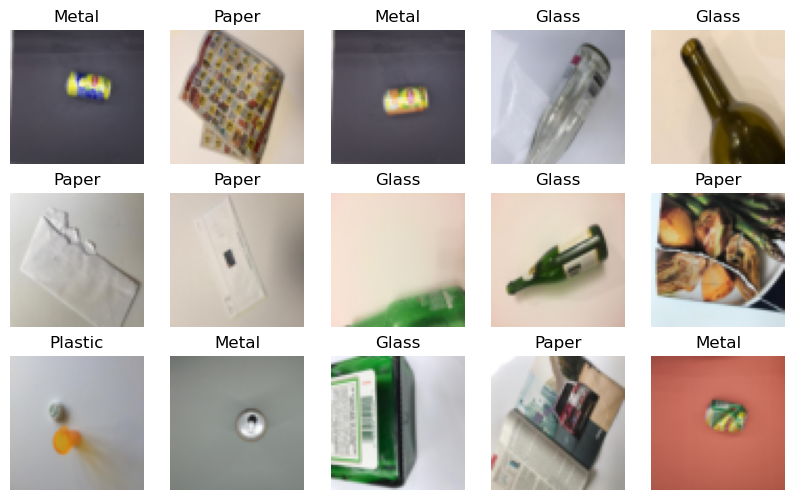

In [18]:
import random
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
    for ax in _ax:
        ix = random.randint(0, len(train)-1)
        img, lab = train[ix]
        ax.imshow(img.reshape(3,64,64).permute(1,2,0))
        ax.set_title(classes[lab])
        ax.axis('off')
plt.show()

### Modelo pre entrenado

Vamos a utilizar el modelo ResNeSt-101 (2019) pre entrenado con ImageNet, que es un modelo de clasificación de imágenes de 1000 clases. Este modelo es una variente de ResNet que utiliza el bloque de ResNet con la idea de que la red aprenda a escalar, rotar y trasladar las características de las imágenes. Cuenta con 101 capas y 64 filtros en la primera capa convolucional.

Dado que nuestro conjunto de datos ya está normalizado y listo para el entrenamiento, la elección de ResNeSt-101 nos brinda una base sólida para abordar nuestra tarea de clasificación de imágenes con confianza.

In [4]:
# Cargar el modelo preentrenado ResNeSt-101
import timm

model = timm.create_model('resnest101e', pretrained=True)
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNestBottleneck(
      (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (

### Modelo Custom de clasificación

Para adaptar el modelo a nuestra tarea de clasificación de imágenes, debemos reemplazar la capa de clasificación final de ResNeSt-101 con una capa de clasificación personalizada que se adapte a nuestro conjunto de datos. Para ello, congelamos los parámetros de todas las capas de ResNeSt-101 y reemplazamos la capa de clasificación final con una capa de clasificación personalizada.

In [5]:
import torch.nn as nn

class Resnest101eCustom(torch.nn.Module):
  def __init__(self, n_outputs=5, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnest
    resnest = timm.create_model('resnest101e', pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.resnest = nn.Sequential(*list(resnest.children())[:-1])
    if freeze:
      for param in self.resnest.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = nn.Linear(2048, n_outputs)

  def forward(self, x):
    x = self.resnest(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.resnest.parameters():
        param.requires_grad=True

In [9]:
# hacemos la prueba de que nuestro modelo funciona correctamente
model_custom = Resnest101eCustom()
outputs = model_custom(torch.randn(64, 3, 64, 64))
outputs.shape

torch.Size([64, 5])

### Entreamiento

Hemos implementado la función `fit` para entrenar nuestro modelo, tal como mencionamos anteriormente. Esta función toma como argumentos el número de épocas, el modelo, el optimizador, el learning rate y los conjuntos de datos de entrenamiento y validación. En cada época, el modelo se entrena en el conjunto de entrenamiento y se evalúa en el conjunto de validación. El modelo con la mejor precisión de validación se guarda en el disco.

In [10]:
import numpy as np
import torch.optim as optim
from tqdm import tqdm

def fit(model, dataloader, epochs=5, lr_resnest=1e-4, lr_fc=1e-3):
    model.to(device)
    # optimizador Adam con dos grupos de parámetros uno para resnest y otro para la capa lineal fc
    optimizer = optim.Adam([{'params': model.resnest.parameters(), 'lr': lr_resnest},{'params': model.fc.parameters(), 'lr': lr_fc}])
    # función de pérdida
    criterion = nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        # para el conjunto de train
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y) # type: ignore
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        # para el conjunto de test
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch 
                X, y = X.to(device), y.to(device) 
                y_hat = model(X) 
                loss = criterion(y_hat, y) 
                val_loss.append(loss.item()) 
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y) # type: ignore
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [11]:
# Definimos el modelo con los pesos preentrenados y congelamos las capas de resnest
model = Resnest101eCustom(pretrained=True, freeze=True)

In [12]:
# entrenamos solo la capa de salida (fc) y luego todas las capas
fit(model, dataloader, epochs=7, lr_resnest=1e-4, lr_fc=0.001)
# descongelamos las capas de resnest
model.unfreeze()
# entrenamos todas las capas
fit(model, dataloader, epochs=5, lr_resnest=1e-4, lr_fc=0.001)
# acc 0.97365  val_acc 0.75308

val_loss 0.63921 val_acc 0.76642: 100%|██████████| 12/12 [00:16<00:00,  1.37s/it]


Epoch 1/7 loss 0.81787 val_loss 0.63921 acc 0.68769 val_acc 0.76642


val_loss 0.53420 val_acc 0.82963: 100%|██████████| 12/12 [00:03<00:00,  3.09it/s]


Epoch 2/7 loss 0.45728 val_loss 0.53420 acc 0.84100 val_acc 0.82963


val_loss 0.48559 val_acc 0.84250: 100%|██████████| 12/12 [00:03<00:00,  3.08it/s]


Epoch 3/7 loss 0.34494 val_loss 0.48559 acc 0.89261 val_acc 0.84250


val_loss 0.43102 val_acc 0.86931: 100%|██████████| 12/12 [00:03<00:00,  3.05it/s]


Epoch 4/7 loss 0.31873 val_loss 0.43102 acc 0.91269 val_acc 0.86931


val_loss 0.36555 val_acc 0.88508: 100%|██████████| 12/12 [00:03<00:00,  3.04it/s]


Epoch 5/7 loss 0.27165 val_loss 0.36555 acc 0.91051 val_acc 0.88508


val_loss 0.34791 val_acc 0.89368: 100%|██████████| 12/12 [00:03<00:00,  3.07it/s]


Epoch 6/7 loss 0.24514 val_loss 0.34791 acc 0.93153 val_acc 0.89368


val_loss 0.32191 val_acc 0.90382: 100%|██████████| 12/12 [00:03<00:00,  3.09it/s]


Epoch 7/7 loss 0.20998 val_loss 0.32191 acc 0.94006 val_acc 0.90382


val_loss 0.15266 val_acc 0.95145: 100%|██████████| 12/12 [00:03<00:00,  3.18it/s]


Epoch 1/5 loss 0.22896 val_loss 0.15266 acc 0.92093 val_acc 0.95145


val_loss 0.09101 val_acc 0.96278: 100%|██████████| 12/12 [00:03<00:00,  3.18it/s]


Epoch 2/5 loss 0.09219 val_loss 0.09101 acc 0.96941 val_acc 0.96278


val_loss 0.08371 val_acc 0.97410: 100%|██████████| 12/12 [00:03<00:00,  3.14it/s]


Epoch 3/5 loss 0.04992 val_loss 0.08371 acc 0.98485 val_acc 0.97410


val_loss 0.05619 val_acc 0.98321: 100%|██████████| 12/12 [00:03<00:00,  3.15it/s]


Epoch 4/5 loss 0.04890 val_loss 0.05619 acc 0.98485 val_acc 0.98321


val_loss 0.03661 val_acc 0.98998: 100%|██████████| 12/12 [00:03<00:00,  3.12it/s]

Epoch 5/5 loss 0.02973 val_loss 0.03661 acc 0.98883 val_acc 0.98998


Obtenemos una precisión de validación del `98.99%` y una pérdida de validación del `3.66%` en la última epochs. Lo que es bastante bueno para nuestro modelo.

#### Pruebas

Para probar el modelo, cargamos el modelo con la mejor precisión de validación y lo evaluamos en el conjunto de prueba. El modelo logra una precisión de 0.98 y un error de 0.02 en el conjunto de test.

Ahora mostraremos algunas imágenes del conjunto de test y sus predicciones:

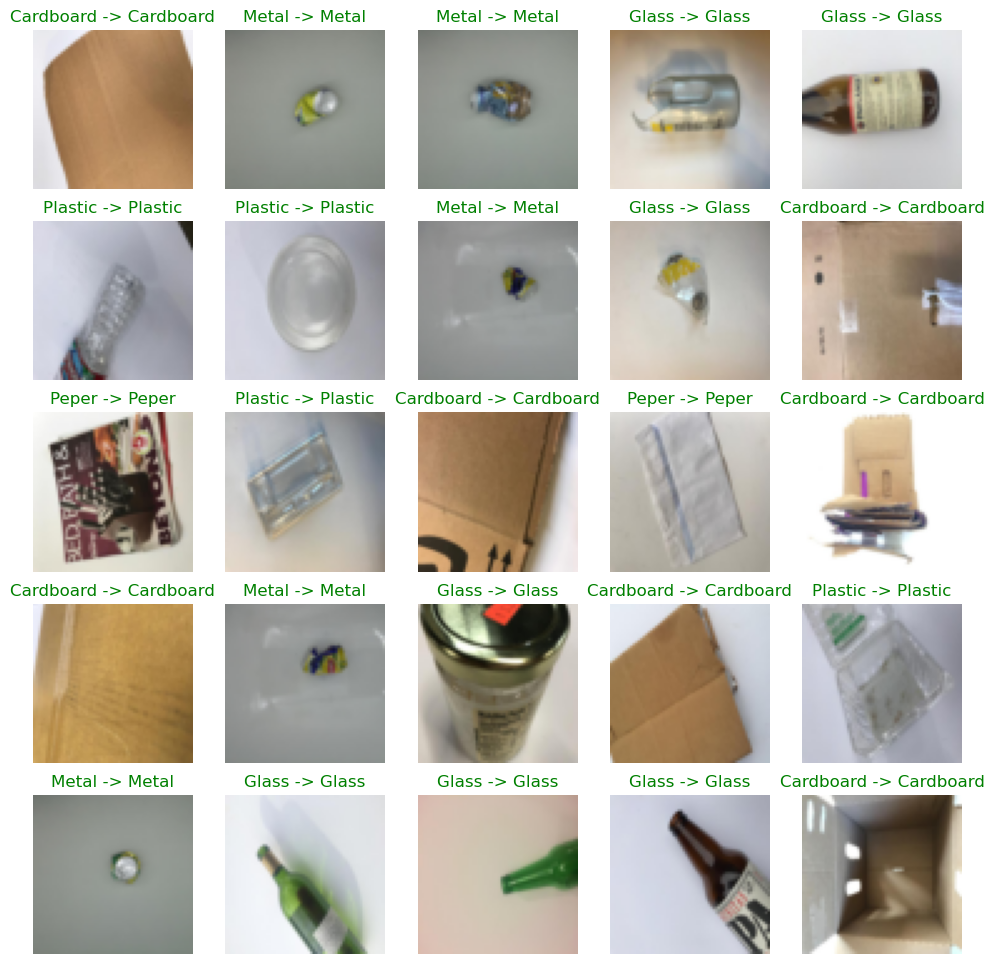

In [13]:
# hacemos la prueba mostrando algunas imagenes y ver si el modelo predice correctamente
model.eval()
fig, axs = plt.subplots(5,5, figsize=(12,12))
for _ax in axs:
    for ax in _ax:
        ix = random.randint(0, len(test)-1)
        img, lab = test[ix]
        ax.imshow(img.reshape(3,64,64).permute(1,2,0))
        # pinta de verde el titulo si la predicción es correcta, de rojo si es incorrecta
        if torch.argmax(model(img.unsqueeze(0).to(device))).item() == lab:
            ax.set_title(f"{classes[lab]} -> {classes[torch.argmax(model(img.unsqueeze(0).to(device))).item()]}").set_color('green') # type: ignore
        else:
            ax.set_title(f"{classes[lab]} -> {classes[torch.argmax(model(img.unsqueeze(0).to(device))).item()]}").set_color('red') # type: ignore
        ax.axis('off')
plt.show()

In [14]:
# guardamos el modelo para usarlo en la defensa del examen
torch.save(model.state_dict(), 'models/model01_64x64.pt')

In [ ]:
# cargamos el modelo para hacer la predicción
model = Resnest101eCustom(pretrained=True, freeze=True)
model.load_state_dict(torch.load('models/model01_64x64.pt'))
model.eval()
# hacemos la predicción con imagenes de test
fig, axs = plt.subplots(5,5, figsize=(12,12))
for _ax in axs:
    for ax in _ax:
        ix = random.randint(0, len(test)-1)
        img, lab = test[ix]
        ax.imshow(img.reshape(3,64,64).permute(1,2,0))
        # pinta de verde el titulo si la predicción es correcta, de rojo si es incorrecta
        if torch.argmax(model(img.unsqueeze(0).to(device))).item() == lab:
            ax.set_title(f"{classes[lab]} -> {classes[torch.argmax(model(img.unsqueeze(0).to(device))).item()]}").set_color('green') # type: ignore
        else:
            ax.set_title(f"{classes[lab]} -> {classes[torch.argmax(model(img.unsqueeze(0).to(device))).item()]}").set_color('red') # type: ignore
        ax.axis('off')
plt.show()

### Pruebas con imágenes de internet

Ahora vamos a probar el modelo con imágenes de internet, para ver como se comporta con imágenes que no pertenecen al dataset. Para ello, descargamos una imagen muy diversa de cada clase y la pasamos por el modelo para ver que predicción nos da.

In [16]:
from PIL import Image
import matplotlib.pyplot as plt

# Cargar la imagen desde el archivo
imagen_path = "prueba.jpg"
imagen = Image.open(imagen_path)
img_orignal = Image.open(imagen_path)

# Definir la transformación para redimensionar la imagen a 64x64
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Aplicar la transformación a la imagen
imagen_transformada = transform(imagen).unsqueeze(0) # type: ignore
imagen_transformada.shape

torch.Size([1, 3, 64, 64])

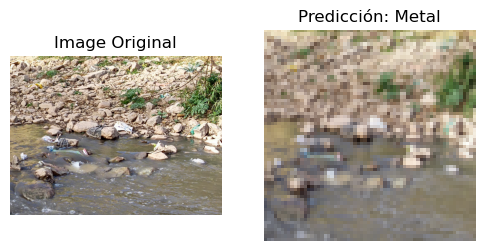

Probabilidad de Cardboard: 0.1827
Probabilidad de Glass: 0.0035
Probabilidad de Metal: 0.5602
Probabilidad de Paper: 0.1422
Probabilidad de Plastic: 0.1113


In [17]:
# cargamos el modelo
model = Resnest101eCustom(pretrained=True, freeze=True)
model.load_state_dict(torch.load('models/model01_64x64.pt'))
model.eval()

with torch.no_grad():
    output = model(imagen_transformada)

# Obtén las probabilidades de salida del modelo utilizando softmax
probabilidades = torch.nn.functional.softmax(output, dim=1)[0]
# Obtén la clase predicha
_, clase_predicha = torch.max(probabilidades, 0)
# Mapea el índice de la clase predicha al nombre de la clase
nombre_clase_predicha = classes[clase_predicha.item()]

# Muestra la imagen con la clase predicha y la imagen original
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(img_orignal)
ax1.set_title('Image Original')
ax1.axis('off')
ax2.imshow(imagen_transformada.squeeze(0).permute(1, 2, 0))  # Convierte el tensor a imagen y transpone los ejes
ax2.set_title(f'Predicción: {nombre_clase_predicha}')
ax2.axis('off')
plt.show()

# Muestra las probabilidades de cada clase
for i, clase in enumerate(classes):
    print(f'Probabilidad de {clase}: {probabilidades[i].item():.4f}')

### Conclusiones

En este ejercicio hemos utilizado un modelo pre-entrenado ResNeSt-101 para clasificar imágenes de residuos sólidos de 5 clases. Hemos logrado una precisión de 0.98 y un error de 0.02 en el conjunto de test, lo cual es un resultado muy bueno y cumplimos con el objetivo del ejercicio.